In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv, MetricVisualizer
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [88]:
train = pd.read_csv("../data/Avito Demand Prediction/train.csv", parse_dates = ["activation_date"])
test = pd.read_csv("../data/Avito Demand Prediction/test.csv", parse_dates = ["activation_date"])

In [89]:
train.shape

(1503424, 18)

In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null datetime64[ns]
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: datetim

In [91]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [92]:
train.describe()

,price,item_seq_number,image_top_1,deal_probability
count,1.418062e+06,1.503424e+06,1.390836e+06,1.503424e+06
mean,3.167081e+05,7.436740e+02,1.241932e+03,1.391306e-01
std,6.689154e+07,5.572522e+03,9.704641e+02,2.600785e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+02,9.000000e+00,4.250000e+02,0.000000e+00
50%,1.300000e+03,2.900000e+01,1.057000e+03,0.000000e+00
75%,7.000000e+03,8.800000e+01,2.217000e+03,1.508700e-01
max,7.950101e+10,2.044290e+05,3.066000e+03,1.000000e+00


**item_id** - Ad id.

**user_id** - User id.

**region** - Ad region.

**city** - Ad city.

**parent_category_name** - Top level ad category as classified by Avito's ad model.

**category_name** - Fine grain ad category as classified by Avito's ad model.

**param_1** - Optional parameter from Avito's ad model.

**param_2** - Optional parameter from Avito's ad model.

**param_3** - Optional parameter from Avito's ad model.

**title** - Ad title.

**description** - Ad description.

**price** - Ad price.

**item_seq_number** - Ad sequential number for user.

**activation_date**- Date ad was placed.

**user_type** - User type.

**image** - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.

**image_top_1** - Avito's classification code for the image.

**deal_probability** - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.

## Пропущенные значения

In [93]:
null_value_stats = train.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

param_1         61576
param_2        654542
param_3        862565
description    116276
price           85362
image          112588
image_top_1    112588
dtype: int64

In [94]:
train["param_1"].fillna("", inplace=True)
train["param_2"].fillna("", inplace=True)
train["param_3"].fillna("", inplace=True)
train["description"].fillna("", inplace=True)
train["price"].fillna(-999, inplace=True)
train["image"].fillna("", inplace=True)
train["image_top_1"].fillna(-999, inplace=True)

In [95]:
null_value_stats = test.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

param_1         22910
param_2        233229
param_3        306331
price           30585
image           42609
image_top_1     42609
dtype: int64

In [96]:
test["param_1"].fillna("", inplace=True)
test["param_2"].fillna("", inplace=True)
test["param_3"].fillna("", inplace=True)
test["price"].fillna(-999, inplace=True)
test["image"].fillna("", inplace=True)
test["image_top_1"].fillna(-999, inplace=True)

## Feature Engineering

In [97]:
train["weekday"] = train["activation_date"].dt.weekday
test["weekday"] = test["activation_date"].dt.weekday

train["has_image"] = train['image'].apply(lambda x: 0 if x == '' else 1)
test["has_image"] = test['image'].apply(lambda x: 0 if x == '' else 1)

In [98]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,weekday,has_image
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,,,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,1,1
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,,,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,6,1
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",,,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,0,1
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,,,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,5,1
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,3,1


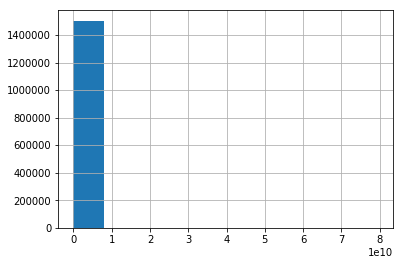

In [99]:
train['price'].hist();

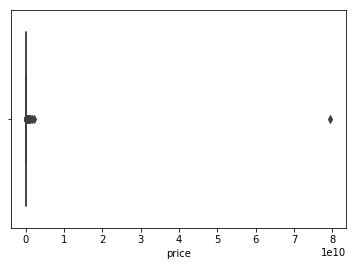

In [100]:
sns.boxplot(train['price']); # Ящик с усами: середина это медиана, границы ящика это 0.25- и 0.75-квартили,усы - это полтора интеркваритильных размаха от медианы. То, что за усами - это выбросы 

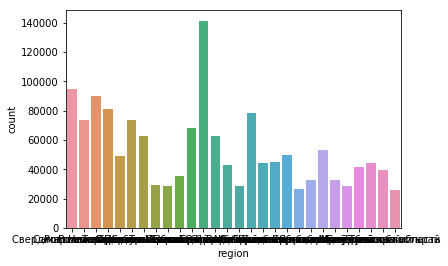

In [101]:
sns.countplot(train['region']);

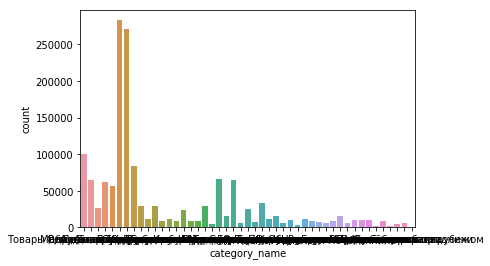

In [102]:
sns.countplot(train['category_name']);

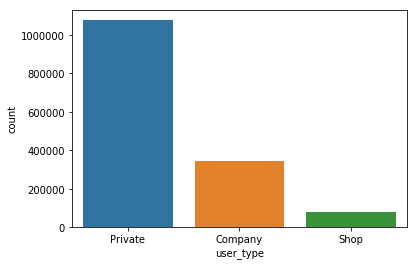

In [103]:
sns.countplot(train['user_type']);

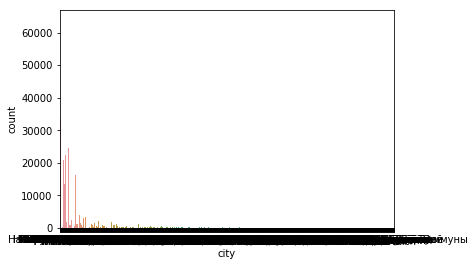

In [104]:
sns.countplot(train['city']);

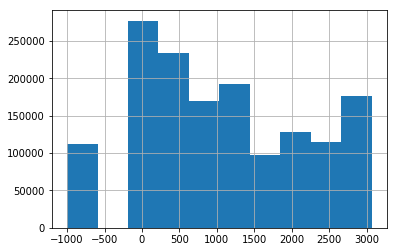

In [105]:
train['image_top_1'].hist();

In [106]:
null_value_stats = train.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

In [107]:
X = train.drop(['image', 'activation_date', 'deal_probability', 'item_id'], axis=1)
y = train['deal_probability']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test.drop(['image', 'activation_date', 'item_id'], axis=1)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [108]:
print(X.dtypes)

categorical_features_indices = np.where(X.dtypes != np.float)[0]

user_id                  object
region                   object
city                     object
parent_category_name     object
category_name            object
param_1                  object
param_2                  object
param_3                  object
title                    object
description              object
price                   float64
item_seq_number           int64
user_type                object
image_top_1             float64
weekday                   int64
has_image                 int64
dtype: object


In [109]:
model = CatBoostRegressor(
    loss_function='RMSE',
    random_seed=42,
    logging_level='Silent',
    iterations=900,
    learning_rate=0.01,
    task_type='GPU',
    depth=10
)

In [110]:
null_value_stats = X_train.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

In [111]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    logging_level='Verbose',  # you can uncomment this for text output
    use_best_model=True
);

CatboostError: catboost/libs/train_lib/train_model.cpp:677: Can't load GPU learning library. Module was not compiled or CUDA version/driver  is incompatible with package

In [ ]:
model.save_model('avito_catboost_model.dump')

In [ ]:
pred = model.predict(X_test, verbose=True)

In [ ]:
pred[:10]

In [ ]:
def normalize(x):
    return 0 if x < 0 else (1 if x > 1 else x)

pred2 = [normalize(x) for x in pred]

In [ ]:
pred2[:10]

In [ ]:
submission = pd.DataFrame(columns=['item_id', 'deal_probability'])

In [ ]:
submission['item_id'] = test['item_id']
submission['deal_probability'] = pred2

In [ ]:
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)